In [1]:
%%capture
%pip install -q calplot
%pip install -q plotly

subjectid="MIND006"

#PT UID
part = 'U1918167344'
#grab this as the intake info from REDCAP

#Start date in MM/DD/YYYY
start = '10/1/2024'
# Make start date the day eligible

In [2]:
# import packages
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import os
import requests
import sys
import datetime
from datetime import datetime
import time
import pytz
import calplot

import pandas as pd

# Set creds


os.environ['LAMP_ACCESS_KEY'] = os.getenv('LAMPACCESSKEY')
os.environ['LAMP_SECRET_KEY'] = os.getenv('LAMPSERVERKEY')
os.environ['LAMP_SERVER_ADDRESS'] = 'api.lamp.digital'

# Define REDCap API details
api_url = "https://redcap.ucdenver.edu/api/"
api_token = os.getenv('REDCAPAPI')


#clinic_ids=pd.read_csv('pt_start_dates.csv')

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

import LAMP
LAMP.connect()

import cortex
import numpy as np
import altair as alt
from datetime import datetime, timezone
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.basicConfig(level=3)
logging.getLogger('matplotlib').disabled = True
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('numexpr.utils').disabled = True
logging.getLogger('feature_types:_wrapper2').disabled = True


from IPython.display import display, Markdown
import plotly.graph_objects as go
import plotly.offline as pyo


from datetime import datetime, timezone

MS_IN_DAY = 24 * 3600 * 1000

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Settings for Cortex

run_sleep=True
# default end date is now
end_date = cortex.now()


def timestamp(dt):
    local = pytz.timezone("America/New_York")
    date = datetime.strptime(dt, '%m/%d/%Y')
    local_dt = local.localize(date, is_dst=None)
    utc_dt = local_dt.astimezone(pytz.utc)
    utc_dt.replace(tzinfo=timezone.utc).timestamp() * 1000
    return int(utc_dt.replace(tzinfo=timezone.utc).timestamp() * 1000)
start_date = timestamp(start)

# Digital Clinic Patient Handout

This document presents the data that was collected during your time in the mindLAMP Study.  Feel free to reach out to the study team (digitalclinic@cuanschutz.edu) with any questions.


In [4]:

# Function to fetch data from REDCap
def fetch_redcap_data(record_id, event, fields):
    payload = {
        'token': api_token,
        'content': 'record',
        'format': 'json',
        'records[0]': record_id,
        'events[0]': event,
        'type': 'flat',
        'rawOrLabel': 'label'
    }
    
    # Add multiple fields to the payload
    for i, field in enumerate(fields):
        payload[f'fields[{i}]'] = field
    
    response = requests.post(api_url, data=payload)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Fetch the gender, age, and race fields for record in intake_arm_2
record_id = subjectid
event = "intake_arm_2"
fields = ["gender", "age", "race"]

data = fetch_redcap_data(record_id, event, fields)

# Extract and directly use the fetched data for age, gender, and race
if data:
    subject = f'Participant: {subjectid}'
    age = f'Age: {data[0].get("age", "N/A")}'
    gender = f'Gender: {data[0].get("gender", "N/A")}'
    race = f'Race: {data[0].get("race", "N/A")}'
    
    # Display the information with font size 4
    display(Markdown(f'<font size="4"><strong>{subject}<br/>{age}<br/>{gender}<br/>{race}</strong></font>'))


<font size="4"><strong>Participant: MIND006<br/>Age: 90<br/>Gender: Woman<br/>Race: White</strong></font>

### Baseline Scores

Throughout your time in the study, you will complete three surveys: an Intake survey during your first session with your Digital Navigator, an Interim survey after your third meeting with your clinician, and a Completion survey at the end of your last appointment. 

The graph below displays your responses to survey questions measuring anxiety, depression, and dysfunction (dysfunction represents how difficult it is to manage your day-to-day life and responsibilities). You can toggle over the survey category on the right to view all your survey responses together, or to only view your results from one of the surveys (just the Intake, for example). Clicking on the points on the graph shows your numerical score and what it is out of. Higher scores indicate having more symptoms of depression, anxiety, and/or dysfunction.

We hope this graph will help you see what areas you have made progress in during your time in the study. 

In [5]:
# The functions below will grab REDCap data to be used in graphs focused on weekly surveys

from datetime import datetime
import requests
import pandas as pd
import numpy as np  # Import numpy for NaN

# Function to fetch REDCap scores with events and fields
def fetch_redcap_scores(record_id, events, fields):
    payload = {
        'token': api_token,
        'content': 'record',
        'format': 'json',
        'records[0]': record_id,
        'type': 'flat'
    }
    
    # Add the events to the payload
    for i, event in enumerate(events):
        payload[f'events[{i}]'] = event
    
    # Add the fields to the payload
    for i, field in enumerate(fields):
        payload[f'fields[{i}]'] = field

    response = requests.post(api_url, data=payload)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# List of events
events = [
    "pretx_arm_2", "visit_1_arm_2", "visit_2_arm_2",
    "visit_3_arm_2", "visit_4_arm_2", "visit_5_arm_2", "visit_6_arm_2"
]

# Helper function to process data
def process_data(data, score_field, date_field, event_list, survey_name):
    scores = []
    event_counter = 0  # Initialize counter for events
    for record in data:
        if score_field in record and date_field in record:  # Ensure both fields exist
            score = record[score_field]
            event = event_list[event_counter] if event_counter < len(event_list) else "Unknown Event"
            
            # Handle the date parsing carefully
            date_str = record.get(date_field, None)
            date = np.nan  # Initialize with NaN
            
            if date_str:
                try:
                    date = datetime.strptime(date_str, '%Y-%m-%d')
                except ValueError:
                    date = np.nan
            
            if score == '':
                score = np.nan

            scores.append({'Event': event, 'Score': score, 'Date': date, 'Survey': survey_name})
            event_counter += 1

    return scores

record_id = subjectid

# Fetch PHQ-9 data
phq9_data = fetch_redcap_scores(record_id, events, ["phq9_score", "phq9_date"])
phq9_scores = process_data(phq9_data, "phq9_score", "phq9_date", events, "Weekly PHQ-9 Survey")

# Handle intake_arm_2 for PHQ-9 separately
intake_phq9_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["eligibility_phq_score", "eligibility_date"])
if intake_phq9_data:
    for record in intake_phq9_data:
        eligibility_date_str = record.get("eligibility_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        phq_score = record.get("eligibility_phq_score", np.nan)
        if phq_score == '':
            phq_score = np.nan

        phq9_scores.append({'Event': 'intake_arm_2', 'Score': phq_score, 'Date': eligibility_date, 'Survey': 'Weekly PHQ-9 Survey'})

# Fetch and process GAD-7 data
gad7_data = fetch_redcap_scores(record_id, events, ["gad7_score", "gad7_date"])
gad7_scores = process_data(gad7_data, "gad7_score", "gad7_date", events, "Weekly GAD-7 Survey")

# Handle intake_arm_2 for GAD-7 separately
intake_gad7_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["eligibility_gad_score", "eligibility_date"])
if intake_gad7_data:
    for record in intake_gad7_data:
        eligibility_date_str = record.get("eligibility_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        gad_score = record.get("eligibility_gad_score", np.nan)
        if gad_score == '':
            gad_score = np.nan

        gad7_scores.append({'Event': 'intake_arm_2', 'Score': gad_score, 'Date': eligibility_date, 'Survey': 'Weekly GAD-7 Survey'})


# Fetch Sleep Survey data
sleep_data = fetch_redcap_scores(record_id, events, ["sleep_score", "sleep_date"])
sleep_scores = process_data(sleep_data, "sleep_score", "sleep_date", events, "Weekly Sleep Survey")

# Handle intake_arm_2 for Sleep Survey separately
intake_sleep_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["sleep_score", "sleep_date"])
if intake_sleep_data:
    for record in intake_sleep_data:
        eligibility_date_str = record.get("sleep_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        sleep_score = record.get("sleep_score", np.nan)
        if sleep_score == '':
            sleep_score = np.nan

        sleep_scores.append({'Event': 'intake_arm_2', 'Score': sleep_score, 'Date': eligibility_date, 'Survey': 'Weekly Sleep Survey'})



# Fetch and process SDS data
sds_data = fetch_redcap_scores(record_id, events, ["sds_score", "sds_date"])
sds_scores = process_data(sds_data, "sds_score", "sds_date", events, "Weekly SDS Survey")

# Handle intake_arm_2 for SDS separately
intake_sds_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["sds_score", "sds_date"])
if intake_sds_data:
    for record in intake_sds_data:
        eligibility_date_str = record.get("sds_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        sds_score = record.get("sds_score", np.nan)
        if sds_score == '':
            sds_score = np.nan

        sds_scores.append({'Event': 'intake_arm_2', 'Score': sds_score, 'Date': eligibility_date, 'Survey': 'Weekly SDS Survey'})



# Fetch and process ESA data
esa_data = fetch_redcap_scores(record_id, events, ["esa_score", "esa_date"])
esa_scores = process_data(esa_data, "esa_score", "esa_date", events, "Weekly ESA Survey")

# Handle intake_arm_2 for ESA separately
intake_esa_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["esa_score", "esa_date"])
if intake_esa_data:
    for record in intake_esa_data:
        eligibility_date_str = record.get("esa_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        esa_score = record.get("esa_score", np.nan)
        if esa_score == '':
            esa_score = np.nan

        esa_scores.append({'Event': 'intake_arm_2', 'Score': esa_score, 'Date': eligibility_date, 'Survey': 'Weekly ESA Survey'})


# Fetch and process MSPSS data
mspss_data = fetch_redcap_scores(record_id, events, ["mspss_score", "mspss_date"])
mspss_scores = process_data(mspss_data, "mspss_score", "mspss_date", events, "Weekly MSPSS Survey")

# Handle intake_arm_2 for MSPSS separately
intake_mspss_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["mspss_score", "mspss_date"])
if intake_mspss_data:
    for record in intake_mspss_data:
        eligibility_date_str = record.get("mspss_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        mspss_score = record.get("mspss_score", np.nan)
        if mspss_score == '':
            mspss_score = np.nan

        mspss_scores.append({'Event': 'intake_arm_2', 'Score': mspss_score, 'Date': eligibility_date, 'Survey': 'Weekly MSPSS Survey'})


# Fetch and process Flourishing scale data
fs_data = fetch_redcap_scores(record_id, events, ["fs_score", "fs_date"])
fs_scores = process_data(fs_data, "fs_score", "fs_date", events, "Weekly Flourishing Survey")

# Handle intake_arm_2 for Flourishing scale separately
intake_fs_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["fs_score", "fs_date"])
if intake_fs_data:
    for record in intake_fs_data:
        eligibility_date_str = record.get("fs_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        fs_score = record.get("fs_score", np.nan)
        if fs_score == '':
            fs_score = np.nan

        fs_scores.append({'Event': 'intake_arm_2', 'Score': fs_score, 'Date': eligibility_date, 'Survey': 'Weekly Flourishing Survey'})



# Fetch and process PSE data
pse_data = fetch_redcap_scores(record_id, events, ["pse_score", "pse_date"])
pse_scores = process_data(pse_data, "pse_score", "pse_date", events, "Weekly PSE Survey")

# Handle intake_arm_2 for PSE separately
intake_pse_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["pse_score", "pse_date"])
if intake_pse_data:
    for record in intake_pse_data:
        eligibility_date_str = record.get("pse_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        pse_score = record.get("pse_score", np.nan)
        if pse_score == '':
            pse_score = np.nan

        pse_scores.append({'Event': 'intake_arm_2', 'Score': pse_score, 'Date': eligibility_date, 'Survey': 'Weekly PSE Survey'})


# Fetch and process DHLS data
dhls_data = fetch_redcap_scores(record_id, events, ["dhls_score", "dhls_date"])
dhls_scores = process_data(dhls_data, "dhls_score", "dhls_date", events, "Weekly DHLS Survey")

# Handle intake_arm_2 for DHLS separately
intake_dhls_data = fetch_redcap_scores(record_id, ["intake_arm_2"], ["dhls_score", "dhls_date"])
if intake_dhls_data:
    for record in intake_dhls_data:
        eligibility_date_str = record.get("dhls_date", None)
        eligibility_date = np.nan

        if eligibility_date_str:
            try:
                eligibility_date = datetime.strptime(eligibility_date_str, '%Y-%m-%d')
            except ValueError:
                eligibility_date = np.nan

        dhls_score = record.get("dhls_score", np.nan)
        if dhls_score == '':
            dhls_score = np.nan

        dhls_scores.append({'Event': 'intake_arm_2', 'Score': dhls_score, 'Date': eligibility_date, 'Survey': 'Weekly DHLS Survey'})





# Combine all scores
all_scores = phq9_scores + gad7_scores + sleep_scores + sds_scores + esa_scores + mspss_scores + fs_scores + pse_scores + dhls_scores

# Convert to DataFrame
weekly_df = pd.DataFrame(all_scores)

# Format 'Date' column to match 'YYYY-MM-DD' format, handle NaT separately
def format_date(x):
    if pd.isna(x):  # Check for NaT
        return np.nan  # Return NaN for NaT values
    elif isinstance(x, datetime):  # Check if it's a valid datetime object
        return x.strftime('%Y-%m-%d')
    return np.nan  # For any other case, return NaN

# Apply the formatting to the 'Date' column
weekly_df['Date'] = weekly_df['Date'].apply(format_date)

# Filter out rows where the 'Score' is NaN
filtered_df = weekly_df[~weekly_df['Score'].isna()]

# Display the filtered DataFrame
print(filtered_df)


            Event Score        Date                     Survey
0     pretx_arm_2    13  2024-11-10        Weekly PHQ-9 Survey
1   visit_1_arm_2    11  2024-11-11        Weekly PHQ-9 Survey
2   visit_2_arm_2    10  2024-11-12        Weekly PHQ-9 Survey
3   visit_3_arm_2     5  2024-11-13        Weekly PHQ-9 Survey
4   visit_4_arm_2     3  2024-11-14        Weekly PHQ-9 Survey
5   visit_5_arm_2     6  2024-11-15        Weekly PHQ-9 Survey
6   visit_6_arm_2     3  2024-11-16        Weekly PHQ-9 Survey
7    intake_arm_2     9  2024-11-09        Weekly PHQ-9 Survey
8     pretx_arm_2     7  2024-11-10        Weekly GAD-7 Survey
9   visit_1_arm_2     9  2024-11-11        Weekly GAD-7 Survey
10  visit_2_arm_2    10  2024-11-12        Weekly GAD-7 Survey
11  visit_3_arm_2     6  2024-11-13        Weekly GAD-7 Survey
12  visit_4_arm_2     5  2024-11-14        Weekly GAD-7 Survey
13  visit_5_arm_2     4  2024-11-15        Weekly GAD-7 Survey
14  visit_6_arm_2     1  2024-11-16        Weekly GAD-7

In [6]:
# Function to safely extract a score for a given event and survey
def get_score_for_event(df, event, survey_name):
    # Filter the DataFrame for the given event and survey
    filtered = df[(df['Event'] == event) & (df['Survey'] == survey_name)]
    
    # Check if the filtered DataFrame is empty and return NaN if no data exists
    if filtered.empty or pd.isna(filtered['Score'].iloc[0]):
        return np.nan
    else:
        return filtered['Score'].iloc[0]

# Extract the scores for each event
intake_phq = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly PHQ-9 Survey')
interim_phq = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly PHQ-9 Survey')
final_phq = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly PHQ-9 Survey')

intake_gad = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly GAD-7 Survey')
interim_gad = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly GAD-7 Survey')
final_gad = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly GAD-7 Survey')

intake_sds = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly SDS Survey')
interim_sds = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly SDS Survey')
final_sds = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly SDS Survey')

intake_esa = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly ESA Survey')
interim_esa = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly ESA Survey')
final_esa = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly ESA Survey')

intake_mspss = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly MSPSS Survey')
interim_mspss = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly MSPSS Survey')
final_mspss = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly MSPSS Survey')

intake_fs = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly Flourishing Survey')
interim_fs = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly Flourishing Survey')
final_fs = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly Flourishing Survey')

intake_pse = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly PSE Survey')
interim_pse = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly PSE Survey')
final_pse = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly PSE Survey')

intake_dhls = get_score_for_event(filtered_df, 'intake_arm_2', 'Weekly DHLS Survey')
interim_dhls = get_score_for_event(filtered_df, 'visit_3_arm_2', 'Weekly DHLS Survey')
final_dhls = get_score_for_event(filtered_df, 'visit_6_arm_2', 'Weekly DHLS Survey')



# Print the values to verify
print("Intake PHQ:", intake_phq)
print("Interim PHQ:", interim_phq)
print("Final PHQ:", final_phq)

print("Intake ESA:", intake_esa)
print("Interim ESA:", interim_esa)
print("Final ESA:", final_esa)

print("Intake MSPSS:", intake_mspss)
print("Interim MSPSS:", interim_mspss)
print("Final MSPSS:", final_mspss)

print("Intake FS:", intake_fs)
print("Interim FS:", interim_fs)
print("Final FS:", final_fs)

print("Intake PSE:", intake_pse)
print("Interim PSE:", interim_pse)
print("Final PSE:", final_pse)

print("Intake DHLS:", intake_dhls)
print("Interim DHLS:", interim_dhls)
print("Final DHLS:", final_dhls)


Intake PHQ: 9
Interim PHQ: 5
Final PHQ: 3
Intake ESA: 5
Interim ESA: 3
Final ESA: 5
Intake MSPSS: 84
Interim MSPSS: 60
Final MSPSS: 71
Intake FS: 56
Interim FS: 39
Final FS: 47
Intake PSE: 40
Interim PSE: 28
Final PSE: 31
Intake DHLS: 6
Interim DHLS: 7
Final DHLS: 11


In [7]:
import plotly.graph_objects as go
import pandas as pd

# Define the categories for the radar chart
categories = ['Depression', 'Anxiety', 'Difficulty Functioning']

# Convert inputs to numeric, treating invalid inputs as NaN
intake_phq = pd.to_numeric(intake_phq, errors='coerce')
intake_gad = pd.to_numeric(intake_gad, errors='coerce')
intake_sds = pd.to_numeric(intake_sds, errors='coerce')

interim_phq = pd.to_numeric(interim_phq, errors='coerce')
interim_gad = pd.to_numeric(interim_gad, errors='coerce')
interim_sds = pd.to_numeric(interim_sds, errors='coerce')

final_phq = pd.to_numeric(final_phq, errors='coerce')
final_gad = pd.to_numeric(final_gad, errors='coerce')
final_sds = pd.to_numeric(final_sds, errors='coerce')

# Initialize the figure
fig = go.Figure()

# Check and add intake data if all intake values are available
if pd.notna(intake_phq) and pd.notna(intake_gad) and pd.notna(intake_sds):
    phq_scaled = intake_phq / 27
    gad_scaled = intake_gad / 21
    sds_scaled = intake_sds / 30

    fig.add_trace(go.Scatterpolar(
        r=[phq_scaled, gad_scaled, sds_scaled],
        theta=categories,
        line_color='#F6222E',
        fill='toself',
        name='Intake',
        text=[f'{intake_phq} out of 27', f'{intake_gad} out of 21', f'{intake_sds} out of 30'],
        hovertemplate='Score: %{text}'
    ))

# Check and add interim data if all interim values are available
if pd.notna(interim_phq) and pd.notna(interim_gad) and pd.notna(interim_sds):
    phq_interim_scaled = interim_phq / 27
    gad_interim_scaled = interim_gad / 21
    sds_interim_scaled = interim_sds / 30

    fig.add_trace(go.Scatterpolar(
        r=[phq_interim_scaled, gad_interim_scaled, sds_interim_scaled],
        theta=categories,
        line_color='#3366CC',
        fill='toself',
        name='Interim',
        text=[f'{interim_phq} out of 27', f'{interim_gad} out of 21', f'{interim_sds} out of 30'],
        hovertemplate='Score: %{text}'
    ))

# Check and add final data if all final values are available
if pd.notna(final_phq) and pd.notna(final_gad) and pd.notna(final_sds):
    phq_final_scaled = final_phq / 27
    gad_final_scaled = final_gad / 21
    sds_final_scaled = final_sds / 30

    fig.add_trace(go.Scatterpolar(
        r=[phq_final_scaled, gad_final_scaled, sds_final_scaled],
        theta=categories,
        line_color='#2E8B57',
        fill='toself',
        name='Final',
        text=[f'{final_phq} out of 27', f'{final_gad} out of 21', f'{final_sds} out of 30'],
        hovertemplate='Score: %{text}'
    ))

# Update layout
fig.update_layout(
    polar=dict(radialaxis=dict(visible=False, range=[0, 1])),
    showlegend=True
)

# Display the radar chart if any data is available
if fig.data:
    fig.show()
else:
    print("No valid data to display.")


The graph below displays your responses to survey questions measuring your self efficacy, motivation, digital literacy, emotional self awareness, and perceived social support. Like in the first graph, you can toggle over which survey you are seeing on the right, or you can click on the graph points to look at your numerical scores. Higher scores indicate greater feelings of motivation, self efficacy, self awareness, and social support, or a greater amount of digital literacy. 

The goal of this graph it so show what areas you have grown in during your time in the Digital Clinic. 

In [8]:
import plotly.graph_objects as go
import pandas as pd

# Define the categories for the radar chart
categories = ['Self Efficacy', 'Digital Literacy', 'Emotional Self Awareness', 'Perceived Social Support', 'Flourishing Scale']

# Convert inputs to numeric, treating invalid inputs as NaN
intake_pse = pd.to_numeric(intake_pse, errors='coerce')
intake_dhls = pd.to_numeric(intake_dhls, errors='coerce')
intake_esa = pd.to_numeric(intake_esa, errors='coerce')
intake_mspss = pd.to_numeric(intake_mspss, errors='coerce')
intake_fs = pd.to_numeric(intake_fs, errors='coerce')


# Initialize the figure
fig = go.Figure()

# Check and add intake data if all intake values are available
if pd.notna(intake_pse) and pd.notna(intake_dhls) and pd.notna(intake_esa) and pd.notna(intake_mspss) and pd.notna(intake_fs):
    pse_scaled = intake_pse / 40
    dhls_scaled = intake_dhls / 12
    esa_scaled = intake_esa / 5
    mspss_scaled = intake_mspss / 84
    fs_scaled = intake_fs / 56

    fig.add_trace(go.Scatterpolar(
        r=[pse_scaled, dhls_scaled, esa_scaled, mspss_scaled, fs_scaled],
        theta=categories,
        line_color='#F6222E',
        fill='toself',
        name='Intake',
        text=[f'{intake_pse} out of 40', f'{intake_dhls} out of 12', f'{intake_esa} out of 5', f'{intake_mspss} out of 84', f'{intake_fs} out of 56'],
        hovertemplate='Score: %{text}'
    ))


interim_pse = pd.to_numeric(interim_pse, errors='coerce') 
interim_dhls = pd.to_numeric(interim_dhls, errors='coerce') 
interim_esa = pd.to_numeric(interim_esa, errors='coerce')  
interim_mspss = pd.to_numeric(interim_mspss, errors='coerce')  
interim_fs = pd.to_numeric(interim_fs, errors='coerce')  


if pd.notna(interim_pse) and pd.notna(interim_dhls) and pd.notna(interim_esa) and pd.notna(interim_mspss) and pd.notna(interim_fs):
    pse_interim_scaled = interim_pse / 40
    dhls_interim_scaled = interim_dhls / 12
    esa_interim_scaled = interim_esa / 5
    mspss_interim_scaled = interim_mspss / 84
    fs_interim_scaled = interim_fs / 56

    fig.add_trace(go.Scatterpolar(
        r=[pse_interim_scaled, dhls_interim_scaled, esa_interim_scaled, mspss_interim_scaled, fs_interim_scaled],
        theta=categories,
        line_color='#3366CC',
        fill='toself',
        name='Interim',
        text=[f'{interim_pse} out of 40', f'{interim_dhls} out of 12', f'{interim_esa} out of 5', f'{interim_mspss} out of 84', f'{interim_fs} out of 56'],
        hovertemplate='Score: %{text}'
    ))



final_pse = pd.to_numeric(final_pse, errors='coerce')  
final_dhls = pd.to_numeric(final_dhls, errors='coerce')  
final_esa = pd.to_numeric(final_esa, errors='coerce')  
final_mspss = pd.to_numeric(final_mspss, errors='coerce')  
final_fs = pd.to_numeric(final_fs, errors='coerce')  

if pd.notna(final_pse) and pd.notna(final_dhls) and pd.notna(final_esa) and pd.notna(final_mspss) and pd.notna(final_fs):
    pse_final_scaled = final_pse / 40
    dhls_final_scaled = final_dhls / 12
    esa_final_scaled = final_esa / 5
    mspss_final_scaled = final_mspss / 84
    fs_final_scaled = final_fs / 56

    fig.add_trace(go.Scatterpolar(
        r=[pse_final_scaled, dhls_final_scaled, esa_final_scaled, mspss_final_scaled, fs_final_scaled],
        theta=categories,
        line_color='#2E8B57',
        fill='toself',
        name='Final',
        text=[f'{final_pse} out of 40', f'{final_dhls} out of 12', f'{final_esa} out of 5', f'{final_mspss} out of 84', f'{final_fs} out of 56'],
        hovertemplate='Score: %{text}'
    ))



# Update layout
fig.update_layout(
    polar=dict(radialaxis=dict(visible=False, range=[0, 1])),
    showlegend=True
)

# Display the radar chart if any data is available
if fig.data:
    fig.show()
else:
    print("No valid data to display.")


In [9]:
def free_response(part_id):
    '''This function returns participant responses to CBT exercises, Triggers,
    and Patient Activation and Empowerment each week.'''

    MS_IN_DAY = 86400000
    one_week_ago = (cortex.now() - (7 * MS_IN_DAY))
    activity_event_dict = LAMP.ActivityEvent.all_by_participant(part_id)['data']
    cbt_list = []
    triggers_list = []
    pae_list = []
    non_dep_events = []

    try:
        for event in activity_event_dict:
            try:
                event['activity'] = LAMP.Activity.view(event['activity'])['data'][0]['name']
                non_dep_events.append(event)
            except:
                continue
        for event in non_dep_events:
            if (event['timestamp'] < cortex.now()) and (event['timestamp'] > one_week_ago):
                if 'CBT' in event['activity']:
                    cbt_list.append(event)
                if 'Triggers' in event['activity']:
                    triggers_list.append(event)
                if 'Activation and Empowerment' in event['activity']:
                    pae_list.append(event)
                if 'Thinking' in event['activity']:
                    cbt_list.append(event)
        if len(cbt_list) == 0:
            print("Patient did not complete any CBT exercises this week")
        else:
            for exercise in cbt_list:
                print(exercise['activity'])
                print('\033[1m' + str(datetime.fromtimestamp(exercise['timestamp']/1000).date()) + '\033[0m')
                print(" ")
                for question in exercise['temporal_slices']:
                    print('\033[1m' + question['item'] + '\033[0m')
                    print(question['value'])
                    print(" ")
                print(" ")
                print(" ")

        if len(triggers_list) == 0:
            print("Patient did not complete 'Triggers' module this week")
        else:
            for exercise in triggers_list:
                print(exercise['activity'])
                print('\033[1m' + str(datetime.fromtimestamp(exercise['timestamp']/1000).date()) + '\033[0m')
                print(" ")
                for question in exercise['temporal_slices']:
                    print('\033[1m' + question['item'] + '\033[0m')
                    print(question['value'])
                print(" ")
                print(" ")

        if len(pae_list) == 0:
            print("Patient did not complete 'Patient Activation and Empowerment' module this week")
        else:
            for exercise in pae_list:
                print(exercise['activity'])
                print('\033[1m' + str(datetime.fromtimestamp(exercise['timestamp']/1000).date()) + '\033[0m')
                print(" ")
                for question in exercise['temporal_slices']:
                    print('\033[1m' + question['item'] + '\033[0m')
                    print(question['value'])
                print(" ")
                print(" ")
    except:
        print('Oops - something has gone wrong. Check if your participant has any data')

    return(None)



In [10]:
free_response(part)

Patient did not complete any CBT exercises this week
Patient did not complete 'Triggers' module this week
Patient did not complete 'Patient Activation and Empowerment' module this week


### Activity Calendar 

This graph shows the activities that you completed each day. Dates are along the x-axis, while the y-axis shows how many activities you completed that day, and the colors on the bars designate the activity names.

In [11]:
cortex.visualizations.participant.active(part, attach_graphs=True, sample_length=100)

Pulling data from LAMP server for all participants...
Finished pulling data. Generating graphs...
U1918167344 data:


alt.LayerChart(...)

Graphs generated. Attaching Graphs...
Analysis complete


### Weekly Surveys So Far

During your time in the clinic, you completed weekly surveys measuring anxiety (GAD-7), depression (PHQ-9) levels, and sleep quality. The line graph shows your scores over your time in the clinic, with blue measuring anxiety, red measuring depression levels, and green measuring sleep quality. The goal of this graph is to measure your progress with your depression and anxiety symptoms throughout your time in the clinic. 

Higher scores designate higher values of depression and anxiety. Anxiety values are measured from 0 to 21, and depression values are measured from 0 to 27. Your sleep score ranges from 8 to 40, with a 40 representing poor sleep and an 8 representing good sleep. The lower the score, the better your sleep quality.

In [12]:
#code for pulling weekly surveys


sleep_scoring_dict = {'category_list': ['Weekly Sleep Survey'],
                    'questions': {
                    'My sleep was restless.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'I was satisfied with my sleep.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'My sleep was refreshing.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'I had difficulty falling asleep.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'I had trouble staying asleep.':{'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'I had trouble sleeping.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'I got enough sleep.': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    'My sleep quality was...': {'category': 'Weekly Sleep Survey', 'scoring':'map1'},
                    },
                    'map1': {
                        '1': 1,
                        '2': 2,
                        '3': 3,
                        '4': 4,
                        '5': 5
                    },
                   }

sleep_dict = cortex.primary.survey_scores.survey_scores(id=part, start=start_date, end=end_date,scoring_dict=sleep_scoring_dict)
score_list = []
for survey in sleep_dict['data']:
    score_list.append({'timestamp':datetime.fromtimestamp(survey['end']/1000).date(),'score':survey['score']})

sleep = pd.DataFrame(score_list)


In [13]:
print(sleep_dict)

{'timestamp': 1727755200000, 'duration': 5623586000, 'data': [{'start': 1731380077968, 'end': 1731382309098, 'category': 'Weekly Sleep Survey', 'question': 'Weekly Sleep Survey', 'score': 18}, {'start': 1730754616846, 'end': 1730754789557, 'category': 'Weekly Sleep Survey', 'question': 'Weekly Sleep Survey', 'score': 11}, {'start': 1730495924901, 'end': 1730496096279, 'category': 'Weekly Sleep Survey', 'question': 'Weekly Sleep Survey', 'score': 10}, {'start': 1730493957294, 'end': 1730494095812, 'category': 'Weekly Sleep Survey', 'question': 'Weekly Sleep Survey', 'score': 12}, {'start': 1730493588105, 'end': 1730493792663, 'category': 'Weekly Sleep Survey', 'question': 'Weekly Sleep Survey', 'score': 12}], 'has_raw_data': 1}


In [14]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Create Depression DataFrame from PHQ-9 scores
dep_df = weekly_df[weekly_df['Survey'] == "Weekly PHQ-9 Survey"].copy()
dep_df['Score'] = pd.to_numeric(dep_df['Score'], errors='coerce')  # Ensure 'Score' is numeric

# Create Anxiety DataFrame from GAD-7 scores
anx_df = weekly_df[weekly_df['Survey'] == "Weekly GAD-7 Survey"].copy()
anx_df['Score'] = pd.to_numeric(anx_df['Score'], errors='coerce')  # Ensure 'Score' is numeric

# Create Sleep DataFrame from sleep scores
sleep_df = weekly_df[weekly_df['Survey'] == "Weekly Sleep Survey"].copy()
sleep_df['Score'] = pd.to_numeric(sleep_df['Score'], errors='coerce')  # Ensure 'Score' is numeric


# Convert 'Date' columns to datetime for compatibility with plotting
dep_df['Date'] = pd.to_datetime(dep_df['Date'], errors='coerce')
anx_df['Date'] = pd.to_datetime(anx_df['Date'], errors='coerce')
sleep_df['Date'] = pd.to_datetime(sleep_df['Date'], errors='coerce')

dep_df = dep_df.sort_values(by='Date').reset_index(drop=True)
anx_df = anx_df.sort_values(by='Date').reset_index(drop=True)
sleep_df = sleep_df.sort_values(by='Date').reset_index(drop=True)

# Create the figure
fig = go.Figure()

# Add Anxiety data trace
fig.add_trace(go.Scatter(
    x=anx_df['Date'], 
    y=anx_df['Score'], 
    visible=True, 
    name='Weekly Anxiety Survey', 
    mode='lines+markers',
))

# Add Depression data trace
fig.add_trace(go.Scatter(
    x=dep_df['Date'], 
    y=dep_df['Score'], 
    visible=True, 
    name='Weekly Depression Survey', 
    mode='lines+markers',
))

# Add Sleep data trace
fig.add_trace(go.Scatter(
    x=sleep_df['Date'], 
    y=sleep_df['Score'], 
    visible=True, 
    name='Weekly Sleep Survey', 
    mode='lines+markers',
))


# Update the layout for the figure
fig.update_layout(
    title='Weekly Survey Scores', 
    xaxis_title='Date', 
    yaxis_title='Score',
    xaxis=dict(
        showgrid=True,
        tickangle=45,
    ),
    yaxis=dict(
        showgrid=True,
        range=[0, 30],  # Adjusted range to accommodate potential PHQ-9, GAD-7, and SDS scores
    ),
    showlegend=True
)

# Show the figure
fig.show()

#### Quick notes about interpreting correlations:
- The numbers and colors correspond to the strength of the relationship. A correlation of -1 indicates a perfect negative relationship (as one variable increases the other variable decreases), and a correlation of 1 indicates a perfect positive relationship (both variables are increasing or decreasing). 
- A correlation of 0 means there is no linear relationship. However, just because a correlation is 0 does not necessarily mean there is no relationship there. There is always the possibility two variables have a nonlinear relationship.
- Correlation does not equal causation. This graph cannot show that one variable causes a change in another variable, only how changes in variables are associated with each other.

Potential example of interpreting this graph: Maybe you have a negative correlation between mood and steps. A negative correlation indicates that on days when your steps are higher, your mood is higher/better. Questions to think about: How does going on a walk make you feel? Do you usually feel better, worse, or about the same after you go on walks?

In [15]:
score_dict = {'category_list': ['Daily Mood Survey', 'Daily Anxiety Survey', 'Daily Function Survey'],
                    'questions': {
                    'Overall, how would you rate your mood today?': {'category': 'Daily Mood Survey', 'scoring':'M_map'},
                    'Overall, how would I rate my anxiety today?': {'category': 'Daily Anxiety Survey', 'scoring':'A_map'},
                    'I am able to manage my day-to-day life': {'category': 'Daily Function Survey', 'scoring':'F_map'},
                    },
                    'A_map': {
                        '10': 10,
                        '9': 9,
                        '8': 8,
                        '7': 7,
                        '6': 6, 
                        '5': 5, 
                        '4': 4, 
                        '3': 3,
                        '2': 2,
                        '1': 1,
                        '0': 0,
                    },
                    'M_map': {
                        '10': 0,
                        '9': 1,
                        '8': 2,
                        '7': 3,
                        '6': 4, 
                        '5': 5, 
                        '4': 6, 
                        '3': 7,
                        '2': 8,
                        '1': 9,
                        '0': 10,
                    },
                    'F_map': {
                        '4': 0,
                        '3': 1,
                        '2': 2,
                        '1': 3,
                        '0': 4}
                   }

In [16]:
#Pulling passive data
try:
    passive = cortex.run(part,
                            ['screen_duration',
                             # 'nearby_device_count', 
                             'entropy', 'data_quality', 'hometime', 'steps'],
                            feature_params={'screen_duration': {}, 'entropy': {},
                            'data_quality': {"feature":"gps", "bin_size":3600000}},
                            start=start_date,
                            end=end_date)
except Exception as e:
    passive = cortex.run(part,
                            ['screen_duration', 'nearby_device_count','entropy', 'data_quality', 'hometime'],
                            feature_params={'screen_duration': {}, 'entropy': {},
                            'data_quality': {"feature":"gps", "bin_size":3600000}},
                            start=start_date,
                            end=end_date)


[====================] 100%

In [17]:
passive_df = pd.DataFrame()
for key in passive:
    if key != 'steps':
        passive_df[key] = passive[key]['value']
        passive_df['date'] = passive[key]['timestamp']
    else:
        if passive[key].empty:
            continue
        else:
            step_df = passive[key]
            # Convert 'timestamp' to datetime
            step_df['timestamp'] = pd.to_datetime(step_df['timestamp'], errors='coerce')
            # Filter for step count
            step_df = step_df[step_df['type'] == 'step_count']
            # Extract date from timestamp
            step_df['date'] = step_df['timestamp'].dt.date
            # Group by date and calculate max
            step_df = step_df.groupby('date')['value'].max().reset_index()
            # Assign steps to passive df
            passive_df['steps'] = step_df['value']

if 'steps' in passive_df:
    passive_df = passive_df[['date', 'screen_duration', 'entropy', 'data_quality', 'hometime', 'steps']]
else:
    passive_df = passive_df[['date', 'screen_duration', 'entropy', 'data_quality', 'hometime']]



In [18]:
print(passive_df)

             date  screen_duration   entropy  data_quality    hometime  \
0   1727755200000              NaN       NaN      0.000000         NaN   
1   1727841600000              NaN       NaN      0.000000         NaN   
2   1727928000000              NaN       NaN      0.000000         NaN   
3   1728014400000              NaN       NaN      0.000000         NaN   
4   1728100800000              NaN       NaN      0.000000         NaN   
5   1728187200000              NaN       NaN      0.000000         NaN   
6   1728273600000              NaN       NaN      0.000000         NaN   
7   1728360000000              NaN       NaN      0.000000         NaN   
8   1728446400000              NaN       NaN      0.000000         NaN   
9   1728532800000              NaN       NaN      0.000000         NaN   
10  1728619200000              NaN       NaN      0.000000         NaN   
11  1728705600000              NaN       NaN      0.000000         NaN   
12  1728792000000              NaN    

In [19]:
#Gathering Sleep onset/offset for duration
actevent = pd.DataFrame(LAMP.ActivityEvent.all_by_participant(part)["data"])
sleepevent = actevent[actevent['activity'] == 'b73q0szm06aekhd7w3sn']

import pandas as pd
from datetime import datetime, timedelta
import pytz


# Function to convert sleep times to datetime
def convert_sleep_time(time_str, date):
    time = datetime.strptime(time_str, '%I:%M%p').time()
    return datetime.combine(date, time)

# Convert timestamp to datetime in EST
sleepevent['timestamp'] = pd.to_datetime(sleepevent['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

sleepevent['date'] = sleepevent['timestamp'].dt.date

# Calculate sleep duration
sleep_durations = []
for index, row in sleepevent.iterrows():
    # Extract date part of the datetime
    date = row['timestamp'].date()
    
    # Convert sleep onset and offset to datetime
    sleep_onset = convert_sleep_time(sleepevent['temporal_slices'][index][3]['value'], date)
    sleep_offset = convert_sleep_time(sleepevent['temporal_slices'][index][4]['value'], date)
    
    # Adjust for cases where sleep spans across midnight
    if sleep_offset < sleep_onset:
        sleep_offset += timedelta(days=1)
    
    # Calculate duration
    duration = sleep_offset - sleep_onset
    sleep_durations.append(duration.total_seconds() / 3600)  # Convert to hours

# Add sleep duration to the dataframe
sleepevent['sleep_duration_hours'] = sleep_durations


sleepevent.drop(columns = {'temporal_slices', 'duration', 'static_data', 'activity', 'timestamp', '_parent'}, inplace = True)


In [20]:
#Pulling dailies
daily_dict_responses = cortex.primary.survey_scores.survey_scores(id=part,
                                                        start=start_date,
                                                        end=end_date,
                                                        return_ind_ques=1,
                                                        scoring_dict=score_dict)
response_data = daily_dict_responses['data']
function = []
anxiety = []
mood = []

for item in response_data:
    if item['question'] == "Daily Function Survey":
        function.append({'score':item['score'], 'date':item['end']})
    if item['question'] == "Daily Anxiety Survey":
        anxiety.append({'score':item['score'], 'date':item['end']})
    if item['question'] == "Daily Mood Survey":
        mood.append({'score':item['score'], 'date':item['end']})


for dictionary in function:
    dictionary['date'] = datetime.fromtimestamp(dictionary['date']/1000).date()

for dictionary in anxiety:
    dictionary['date'] = datetime.fromtimestamp(dictionary['date']/1000).date()

for dictionary in mood:
    dictionary['date'] = datetime.fromtimestamp(dictionary['date']/1000).date()

daily_df_function = pd.DataFrame(function)
daily_df_anxiety = pd.DataFrame(anxiety)
daily_df_mood = pd.DataFrame(mood)

In [21]:
print(daily_dict_responses)

{'timestamp': 1727755200000, 'duration': 5623586000, 'data': [{'start': 1733284536874, 'end': 1733284783401, 'category': 'Daily Function Survey', 'question': 'Daily Function Survey', 'score': 0}, {'start': 1733284536874, 'end': 1733284783401, 'category': 'Daily Function Survey', 'question': 'I am able to manage my day-to-day life', 'score': 0}, {'start': 1733193864275, 'end': 1733194944402, 'category': 'Daily Function Survey', 'question': 'Daily Function Survey', 'score': 1}, {'start': 1733193864275, 'end': 1733194944402, 'category': 'Daily Function Survey', 'question': 'I am able to manage my day-to-day life', 'score': 1}, {'start': 1732569434574, 'end': 1732569522723, 'category': 'Daily Function Survey', 'question': 'Daily Function Survey', 'score': 3}, {'start': 1732569434574, 'end': 1732569522723, 'category': 'Daily Function Survey', 'question': 'I am able to manage my day-to-day life', 'score': 3}, {'start': 1732039450237, 'end': 1732039457460, 'category': 'Daily Function Survey',

In [22]:
passive_df['date'] = pd.to_datetime(passive_df['date'], unit='ms')

passive_df['date'] = passive_df['date'].dt.tz_localize('UTC')

passive_df['date'] = passive_df['date'].dt.tz_convert('US/Eastern')

passive_df['date'] = passive_df['date'].apply(lambda x: x.date())

if len(daily_df_function) > 0:
    daily_df_function = daily_df_function.groupby('date')['score'].mean().reset_index()
    daily_df_function = daily_df_function.rename(columns=({'score':'difficulty functioning'}))
    passive_df = passive_df.merge(daily_df_function, on=['date'], how='left')
else:
    print("No completed Daily Functioning surveys found")

if len(daily_df_anxiety) > 0:
    daily_df_anxiety = daily_df_anxiety.groupby('date')['score'].mean().reset_index()
    daily_df_anxiety = daily_df_anxiety.rename(columns=({'score':'anxiety'}))
    passive_df = passive_df.merge(daily_df_anxiety, on=['date'], how='left')
else:
    print("No completed Daily Anxiety surveys found")

if len(daily_df_mood) > 0:
    daily_df_mood = daily_df_mood.groupby('date')['score'].mean().reset_index()
    daily_df_mood = daily_df_mood.rename(columns=({'score':'depression'}))
    passive_df = passive_df.merge(daily_df_mood, on=['date'], how='left')
else:
    print("No completed Daily Depression surveys found")
    
if len(sleepevent) > 0:
    sleepevent = sleepevent.groupby('date')['sleep_duration_hours'].mean().reset_index()
    passive_df = passive_df.merge(sleepevent, on=['date'], how='left')
else:
    print("No completed Daily Sleep surveys found")


passive_df['screen_duration'] = passive_df['screen_duration'].replace(0, np.nan)
passive_df['entropy'] = passive_df['entropy'].replace(0, np.nan)


try:
    sleep_df['date'] = sleep_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))
    sleep_df = sleep_df[['date', 'hours']]
    sleep_df.columns = ['date', 'sleep duration']
    passive_df = pd.merge(passive_df, sleep_df, on=['date'])
    passive_df['sleep duration'] = passive_df['sleep duration'].astype(float)

except:
    pass

passive_df['date'] = passive_df['date'].astype(object)
cor_data = (passive_df.corr(min_periods=5).stack()
          .reset_index()   
          .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format)  # Round to 2 decimal


cor_data = cor_data[cor_data['correlation'] != 1.00]

cor_data = cor_data[cor_data['correlation'] != -1.00]

base = alt.Chart(cor_data).transform_filter(
alt.datum.variable > alt.datum.variable2
).encode(
    x='variable2:O',
    y='variable:O'    
)

text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)


cor_plot = base.mark_rect().encode(
    color='correlation:Q'
).properties(
    width=300,
    height=200
)
cor_matrix = cor_plot + text


No completed Daily Sleep surveys found


In [23]:
cor_matrix

alt.LayerChart(...)

### Daily Survey Scores

### Daily Survey Scores and Passive Data Features (Nearby Devices, Hometime, Screentime, Entropy)

The below graphs display passive data features collected from your smarphone with your scores on your daily surveys measuring anxiety, function, and mood. The scale for the passive data features is on the left y-axis, and the scale for the daily surveys is on the right y-axis side. The goal of these graphs is to help display patterns between your passive data features and routines with your mood, anxiety, and function levels. 

For example, you may see that for days on which you were on your phone screen more, your mood was typically higher. 

* NOTE: Higher anxiety levels correspond with increased anxiety; 0 being no anxiety and 10 being the worst. Higher mood levels correspond with a better mood; 1 being the worst and 10 being the best. Higher function levels correspond with feeling like you are more able to manage day-to-day life on a scale of 0 to 4.

Entropy is a measure of how much a participant moves around to different locations. Higher entropy typically means that the participant's time is more evenly split between different locations, while low entropy means that a person spends the vast majority of their time at one location.

Nearby devices is a measure of, if your phone is turned on and connected to bluetooth, how many devices around you are also turned on and connected to bluetooth. It can be used as a measure of sociability. For example, if you are spending a lot of time in spaces with lots of people, like a concert or a busy coffee shop, there will be more people and devices around you. 

In [24]:
passive_df.rename(columns = {'difficulty functioning':'dysfunction'}, inplace = True)
passive_df['screen_duration'] = passive_df['screen_duration']/3600000
passive_df['hometime'] = passive_df['hometime']/3600000

In [25]:
print(passive_df)

          date  screen_duration   entropy  data_quality   hometime    steps  \
0   2024-10-01              NaN       NaN      0.000000        NaN  13628.0   
1   2024-10-02              NaN       NaN      0.000000        NaN      NaN   
2   2024-10-03              NaN       NaN      0.000000        NaN      NaN   
3   2024-10-04              NaN       NaN      0.000000        NaN      NaN   
4   2024-10-05              NaN       NaN      0.000000        NaN      NaN   
5   2024-10-06              NaN       NaN      0.000000        NaN      NaN   
6   2024-10-07              NaN       NaN      0.000000        NaN      NaN   
7   2024-10-08              NaN       NaN      0.000000        NaN      NaN   
8   2024-10-09              NaN       NaN      0.000000        NaN      NaN   
9   2024-10-10              NaN       NaN      0.000000        NaN      NaN   
10  2024-10-11              NaN       NaN      0.000000        NaN      NaN   
11  2024-10-12              NaN       NaN      0.000

In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

def generate_visibility(option_position, total_options, traces_per_option):
    return [True if i // traces_per_option == option_position else False for i in range(total_options * traces_per_option)]

x = passive_df['date']

# Handle missing 'sleep_duration_hours' column
sleep_duration = passive_df['sleep_duration_hours'].fillna(np.nan).tolist() if 'sleep_duration_hours' in passive_df else [np.nan] * len(passive_df)

# Handles missing dep, anx, fxn data in passive_df
#dep_line = passive_df['depression'].fillna(np.nan).tolist() if 'depression' in passive_df else [np.nan] * len(passive_df)
#anx_line = passive_df['anxiety'].fillna(np.nan).tolist() if 'anxiety' in passive_df else [np.nan] * len(passive_df)
#fxn_line = passive_df['dysfunction'].fillna(np.nan).tolist() if 'dysfunction' in passive_df else [np.nan] * len(passive_df)

dep_line = passive_df['depression'].fillna(np.nan).values  # Using `.values` to ensure it’s a proper numpy array
anx_line = passive_df['anxiety'].fillna(np.nan).values
fxn_line = passive_df['dysfunction'].fillna(np.nan).values


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# OPTION 1 = Screentime
fig.add_trace(go.Bar(x=x, y=passive_df['screen_duration'], visible=True, marker=dict(color='#CCE5FF'), name='Screentime'), secondary_y=False)
fig.add_trace(go.Scatter(x=x, y=dep_line, mode='lines+markers', connectgaps=True, line=dict(width=2), visible=True, name='Depression'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=anx_line, mode='lines+markers', connectgaps=True, visible=True, name='Anxiety'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=fxn_line, mode='lines+markers', connectgaps=True, visible=True, name='Difficulty Functioning'), secondary_y=True)

# OPTION 2 = Hometime
fig.add_trace(go.Bar(x=x, y=passive_df['hometime'], visible=False, marker=dict(color='#CCCCFF'), name='Hometime'), secondary_y=False)
fig.add_trace(go.Scatter(x=x, y=dep_line, mode='lines+markers', connectgaps=True, line=dict(width=2), visible=False, name='Depression'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=anx_line, mode='lines+markers', connectgaps=True, visible=False, name='Anxiety'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=fxn_line, mode='lines+markers', connectgaps=True, visible=False, name='Difficulty Functioning'), secondary_y=True)

# OPTION 3 = Entropy
fig.add_trace(go.Bar(x=x, y=passive_df['entropy'], visible=False, marker=dict(color='#CCFF99'), name='Entropy'), secondary_y=False)
fig.add_trace(go.Scatter(x=x, y=dep_line, mode='lines+markers', connectgaps=True, line=dict(width=2), visible=False, name='Depression'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=anx_line, mode='lines+markers', connectgaps=True, visible=False, name='Anxiety'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=fxn_line, mode='lines+markers', connectgaps=True, visible=False, name='Difficulty Functioning'), secondary_y=True)

# OPTION 4 = Sleep
fig.add_trace(go.Bar(x=x, y=sleep_duration, visible=False, marker=dict(color='#FFCC99'), name='Sleep Duration'), secondary_y=False)
fig.add_trace(go.Scatter(x=x, y=dep_line, mode='lines+markers', connectgaps=True, line=dict(width=2), visible=False, name='Depression'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=anx_line, mode='lines+markers', connectgaps=True, visible=False, name='Anxiety'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=fxn_line, mode='lines+markers', connectgaps=True, visible=False, name='Difficulty Functioning'), secondary_y=True)


# OPTION 5 = Nearby Devices
try:
    ppl = cortex.secondary.nearby_device_count.nearby_device_count(id=part, start=start_date,
                                                                    end=end_date, resolution=86400000)['data']
    new_dict = {}
    for timestamp in ppl['data']:
        new_dict[(datetime.fromtimestamp(timestamp['timestamp'] / 1000)).date()] = timestamp['value']
        
    df = pd.Series(new_dict)
    df = pd.DataFrame(df.reset_index())
    df.rename(columns={'index': 'timestamp', 0: 'value'}, inplace=True)
    
    fig.add_trace(go.Bar(x=df['timestamp'], y=df['value'], visible=False, marker=dict(color='#FFCC99'), name='Nearby Devices'), secondary_y=False)
    fig.add_trace(go.Scatter(x=x, y=dep_line, mode='lines+markers', connectgaps=True, line=dict(width=2), visible=False, name='Depression'), secondary_y=True)
    fig.add_trace(go.Scatter(x=x, y=anx_line, mode='lines+markers', connectgaps=True, visible=False, name='Anxiety'), secondary_y=True)
    fig.add_trace(go.Scatter(x=x, y=fxn_line, mode='lines+markers', connectgaps=True, visible=False, name='Difficulty Functioning'), secondary_y=True)

    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                x=1.3,
                y=0.5,
                showactive=True,
                buttons=list([
                    dict(label="Screentime",
                         method="update",
                         args=[{"visible": generate_visibility(0, 5, 4)},
                               {"title": "Screentime"}]),
                    dict(label="Hometime",
                         method="update",
                         args=[{"visible": generate_visibility(1, 5, 4)},
                               {"title": "Hometime"}]),
                    dict(label="Entropy",
                         method="update",
                         args=[{"visible": generate_visibility(2, 5, 4)},
                               {"title": "Entropy"}]),
                    dict(label="Sleep Duration",
                         method="update",
                         args=[{"visible": generate_visibility(3, 5, 4)},
                               {"title": "Sleep Duration"}]),
                    dict(label="Nearby Devices",
                         method="update",
                         args=[{"visible": generate_visibility(4, 5, 4)},
                               {"title": "Nearby Devices"}])
                ]),
            )
        ])
except Exception as e:
    print(f"Error: {e}")
    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                x=1.3,
                y=0.5,
                showactive=True,
                buttons=list([
                    dict(label="Screentime",
                         method="update",
                         args=[{"visible": generate_visibility(0, 4, 4)},
                               {"title": "Screentime"}]),
                    dict(label="Hometime",
                         method="update",
                         args=[{"visible": generate_visibility(1, 4, 4)},
                               {"title": "Hometime"}]),
                    dict(label="Entropy",
                         method="update",
                         args=[{"visible": generate_visibility(2, 4, 4)},
                               {"title": "Entropy"}]),
                    dict(label="Sleep Duration",
                         method="update",
                         args=[{"visible": generate_visibility(3, 4, 4)},
                               {"title": "Sleep Duration"}])
                ]),
            )
        ])

# Set y-axes titles
fig.update_yaxes(title_text="<b>Survey Score</b>", secondary_y=True)
fig.update_yaxes(title_text="<b>Time/Number</b>", secondary_y=False)

fig.show()


Error: list indices must be integers or slices, not str


In [27]:
passive_df['depression'] = pd.Series(passive_df['depression']) if isinstance(passive_df['depression'], list) else passive_df['depression']


#### Steps, shown overlaid with daily anxiety, function, and mood scores. 

Steps are the number of steps you have taken each day, measured using your phone's accelerometer or health app.

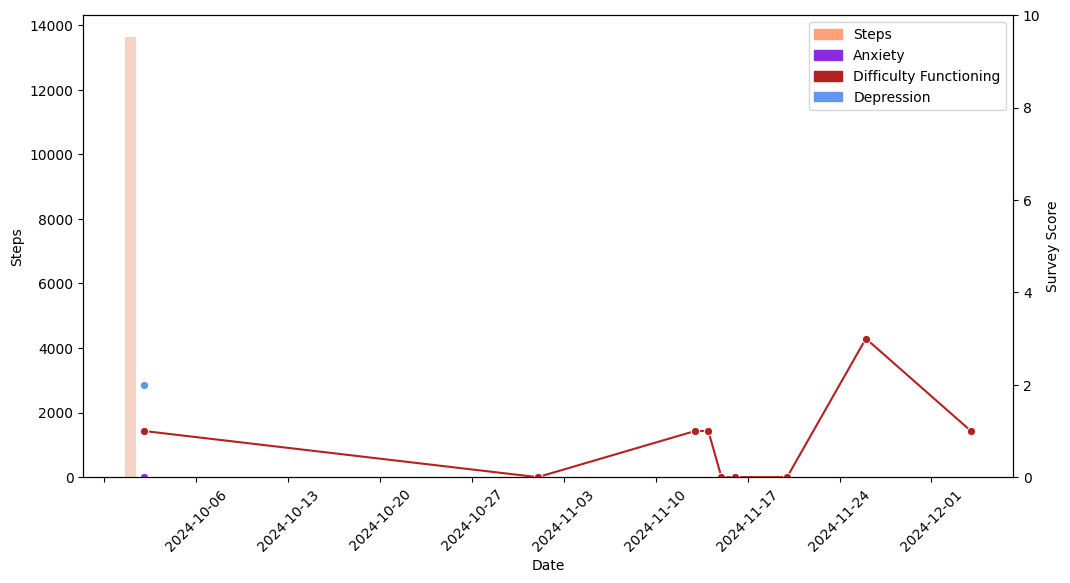

In [28]:
try:
    matplotlib.rc_file_defaults()
    import matplotlib.dates as mdates


    ax1 = sns.set_style(style=None, rc=None )

    fig, ax1 = plt.subplots(figsize=(12,6))
    plt.xticks(rotation = 45)



    sns.barplot(data = passive_df, x='date', y='steps', alpha=0.5, ax=ax1, color='lightsalmon')

    ax2 = ax1.twinx()
    plt.ylim(0, 10)
    sns.lineplot(data = passive_df['anxiety'], marker='o', sort = False, ax=ax2, label='Anxiety', color='blueviolet')
    sns.lineplot(data = passive_df['dysfunction'], marker='o', sort = False, ax=ax2, label='Difficulty Functioning', color='firebrick')
    sns.lineplot(data = passive_df['depression'], marker='o', sort = False, ax=ax2, label='Depression', color='cornflowerblue')


    ax2.set_ylabel('Survey Score')
    ax1.set_ylabel('Steps')

    ax1.set_xlabel('Date')
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    
    colors = {'Steps':'lightsalmon', 'Anxiety':'blueviolet',
         'Difficulty Functioning':'firebrick', 'Depression':'cornflowerblue'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
except:
    print('No step data for this participant. Maybe participant has low data quality or an Android.')

    

### Calendar View

These calendars show heatmaps of all of your passive and active variables collected over your time in the clinic. The month is listed on the bottom, the day of the week is shown on the right, and there is a heat map scale on the far right showing the minimum and maximum values for each variable with the corresponding colors. 

The goal of these graphs is to help pick up on patterns in passive or active data over time, as well as to pick out what days may have been unusual in terms of passive or active data values.

#### Entropy

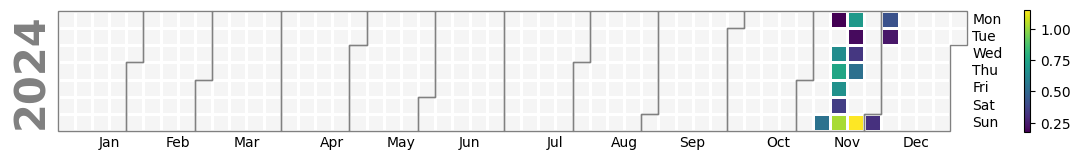

In [29]:
final_df = passive_df
entropy = final_df[['date', 'entropy']]

entropy['date'] = pd.to_datetime(entropy['date'], yearfirst=True)
entropy.set_index('date', inplace=True)
# plot
col = 'entropy'
calplot.calplot(entropy[col], textfiller='-', dropzero=True);

#### Hometime

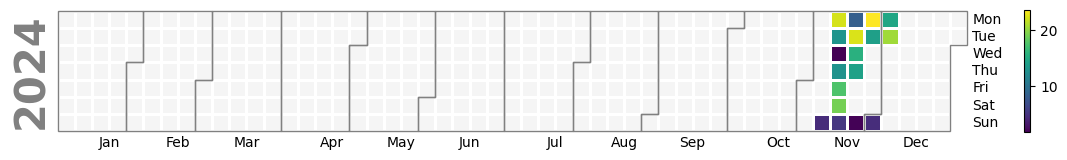

In [30]:
hometime = final_df[['date', 'hometime']]

hometime['date'] = pd.to_datetime(hometime['date'], yearfirst=True)
hometime.set_index('date', inplace=True)
# plot
col = 'hometime'
calplot.calplot(hometime[col], textfiller='-', dropzero=True);

#### Data Quality
Data quality is an indicator of the quality of your passive (gps, step, etc.) data. On days when you have low data quality, your passive data may not be as accurate.

In [31]:
print(final_df.columns)


Index(['date', 'screen_duration', 'entropy', 'data_quality', 'hometime',
       'steps', 'dysfunction', 'anxiety', 'depression'],
      dtype='object')


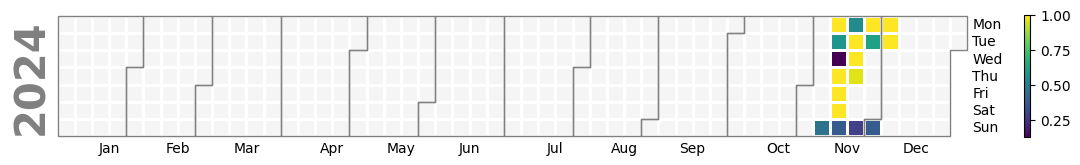

In [32]:
data_quality = final_df[['date', 'data_quality']]


data_quality['date'] = pd.to_datetime(data_quality['date'], yearfirst=True)
data_quality.set_index('date', inplace=True)
# plot
col = 'data_quality'
calplot.calplot(data_quality[col], textfiller='-', dropzero=True);

#### Screen Duration

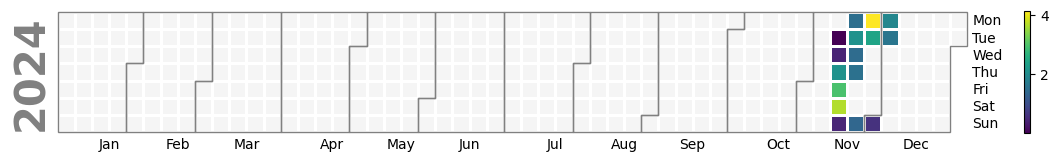

In [33]:
screen_duration = final_df[['date', 'screen_duration']]

screen_duration['date'] = pd.to_datetime(screen_duration['date'], yearfirst=True)
screen_duration.set_index('date', inplace=True)
# plot
col = 'screen_duration'
calplot.calplot(screen_duration[col], textfiller='-', dropzero=True);

#### Steps

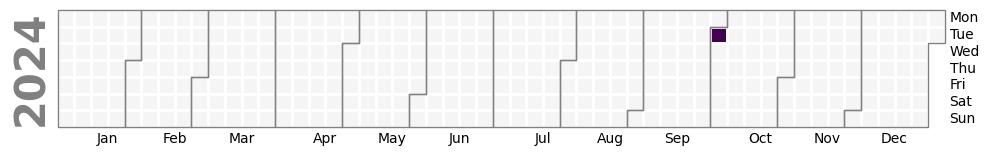

In [34]:
try:
    steps = final_df[['date', 'steps']]

    steps['date'] = pd.to_datetime(steps['date'], yearfirst=True)
    steps.set_index('date', inplace=True)
    # plot
    col = 'steps'
    calplot.calplot(steps[col], textfiller='-', dropzero=True);
except:
    print('No step data for this participant.')

#### Anxiety

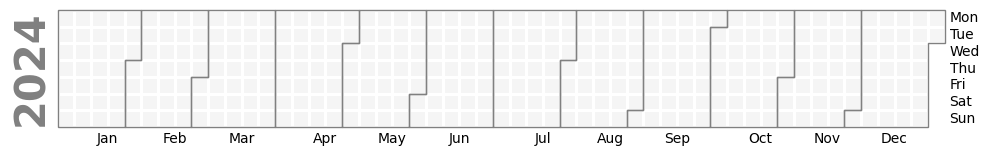

In [35]:
anxiety = final_df[['date', 'anxiety']]

anxiety['date'] = pd.to_datetime(anxiety['date'], yearfirst=True)
anxiety.set_index('date', inplace=True)
# plot
col = 'anxiety'
calplot.calplot(anxiety[col], textfiller='-', dropzero=True);

#### Depression

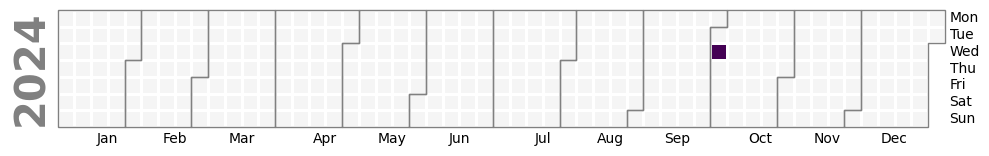

In [36]:
depression = final_df[['date', 'depression']]

depression['date'] = pd.to_datetime(depression['date'], yearfirst=True)
depression.set_index('date', inplace=True)
# plot
col = 'depression'
calplot.calplot(depression[col], textfiller='-', dropzero=True);

#### Difficulty Functioning

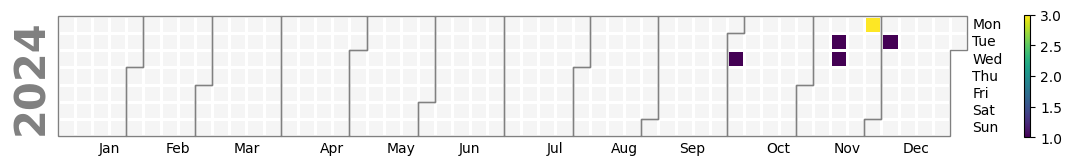

In [37]:
dysfunction = final_df[['date', 'dysfunction']]

dysfunction['date'] = pd.to_datetime(dysfunction['date'], yearfirst=True)
dysfunction.set_index('date', inplace=True)
# plot
col = 'dysfunction'
calplot.calplot(dysfunction[col], textfiller='-', dropzero=True);

#### Sleep Duration

In [41]:
if 'sleep_duration_hours' in final_df.columns:
    sleeptime = final_df[['date', 'sleep_duration_hours']]
    sleeptime['date'] = pd.to_datetime(sleeptime['date'], yearfirst=True)
    sleeptime.set_index('date', inplace=True)
    col = 'sleep_duration_hours'
    calplot.calplot(sleeptime[col], textfiller='-', dropzero=True)
else:
    print("No Daily Sleep Surveys found")

No Daily Sleep Surveys found


In [ ]:
print(final_df.columns)


Index(['date', 'screen_duration', 'entropy', 'data_quality', 'hometime',
       'steps', 'dysfunction', 'anxiety', 'depression'],
      dtype='object')


In [42]:
data_qual=cortex.secondary.data_quality.data_quality(id=part, start=cortex.now()-7*MS_IN_DAY, 
                                                     end=cortex.now(), resolution=86400000, 
                                                     feature='accelerometer', bin_size=10000)['data']
#dq of the last week~! 
import plotly.graph_objects as go
last_week=data_qual[-7:]
dq=[day['value'] for day in last_week]
avg_dq=sum(dq)/7
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = avg_dq,
    # mode = "gauge+number+delta",
    mode='gauge+number',
    title = {'text': "Average Data Quality in the Past Week"},
    delta = {'reference': .44},
    gauge = {'axis': {'range': [None, 1]},
             'bar': {'color': "black", 'line': {'color':'red', 'width':0}, 'thickness': .1},
             'shape': 'angular',
             'steps' : [
                 {'range': [0, .35], 'color': "#E74C3C"},
                 {'range': [.35, .6], 'color': "#F4D03F"},
                 {'range': [.6, .8], 'color': "#27AE60"},
                 {'range': [.8, 1], 'color': "#2471A3"}]}))

fig.show()

In [ ]:
#!jupyter nbconvert --to html --TemplateExporter.exclude_input=True TMLDNreport.ipynb --output-dir=./reports --output=TMLDNreport.html


[NbConvertApp] Converting notebook TMLDNreport.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 571904 bytes to reports/TMLDNreport.html


In [ ]:
# %%capture

cortex.visualizations.participant.active(part, attach_graphs=True)
cortex.visualizations.participant.passive(part,attach_graphs=True)    
cortex.visualizations.participant.cortex_tertiles(part,attach_graphs=False)
